In [44]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
import numpy as np
from numpy import ravel
import pandas as pd
import datetime as dt
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect, cast, desc, and_, distinct

In [2]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [3]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [4]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [5]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [6]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [7]:
#setup inspector to explore tables (measurement)
inspector=inspect(engine)
measure_columns=inspector.get_columns("measurement")
for column in measure_columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [8]:
#explore station columns
station_columns=inspector.get_columns("station")
for column in station_columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


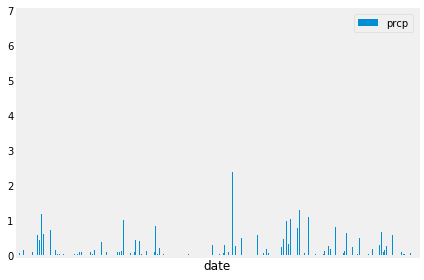

In [9]:
# Calculate the date 1 year ago from the last data point in the database
last_date=str(session.query(Measurement.date).order_by(Measurement.date.desc()).first())
last_date2=dt.datetime.strptime(last_date, "('%Y-%m-%d',)") - dt.timedelta(days=365)
# Perform a query to retrieve the data and precipitation scores
precip=session.query(Measurement.date, Measurement.prcp).filter(Measurement.date>last_date2).all()
precipgb=session.query(Measurement.date, Measurement.prcp).filter(Measurement.date>last_date2).group_by(Measurement.date).all()
# Save the query results as a Pandas DataFrame and set the index to the date column
precip_df= pd.DataFrame(precip)
precip_df_gb= pd.DataFrame(precipgb)
precip_df=precip_df.set_index("date")
precip_df_gb=precip_df_gb.set_index("date")
# Sort the dataframe by date
precip_df_sort=precip_df.sort_index()
precip_df_sort_gb=precip_df_gb.sort_index()
#precip_df_sort
# Use Pandas Plotting with Matplotlib to plot the data
precip_df_sort.plot.bar()
plt.tick_params(
    axis='x',          
    which='both',      
    bottom=False,      
    top=False,         
    labelbottom=False)
plt.tight_layout()
plt.grid(axis="both")


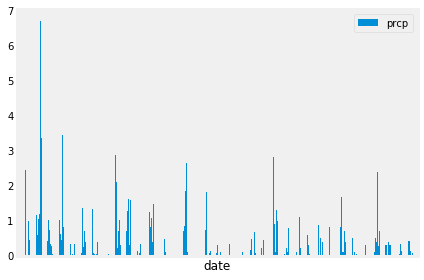

In [10]:
precip_df_sort_gb.plot.bar()
plt.tick_params(
    axis='x',          
    which='both',      
    bottom=False,      
    top=False,         
    labelbottom=False)
plt.tight_layout()
plt.grid(axis="both")

In [11]:
# Use Pandas to calcualte the summary statistics for the precipitation data
precip_df_sort.describe()

,prcp
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [12]:
# Design a query to show how many stations are available in this dataset?
session.query(Station.id).count()

9

In [13]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
session.query(Measurement.station, func.count(Measurement.station)).group_by(Measurement.station).order_by(desc(func.count(Measurement.station))).all()

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [14]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
most_active="USC00519281"
session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).filter(Measurement.station==most_active).all()

[(54.0, 85.0, 71.66378066378067)]

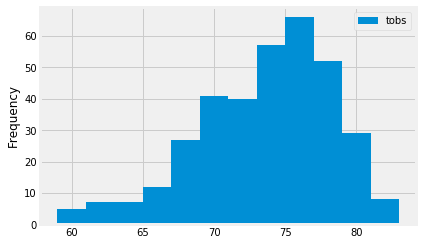

In [15]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
last_date3=str(session.query(Measurement.date).filter(Measurement.station==most_active).order_by(Measurement.date.desc()).first())
last_date4=dt.datetime.strptime(last_date, "('%Y-%m-%d',)") - dt.timedelta(days=365)
temp=session.query(Measurement.tobs).filter(and_(Measurement.date>last_date4, Measurement.station==most_active)).all()
temp_df=pd.DataFrame(temp)
temp_df.plot.hist(bins=12)

In [16]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [17]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
temp_new=[]
temp=str(calc_temps('2015-03-01', '2015-03-31'))
temp_values=temp.split(",")
for temp in temp_values:
    new=temp.replace(" ", "")
    new=new.replace("[", "")
    new=new.replace("]", "")
    new=new.replace("(", '')
    new=new.replace(")", "")
    temp_new.append(float(new))
temp_new


[56.0, 69.44390243902438, 80.0]

Text(0,0.5,'Temp (F)')

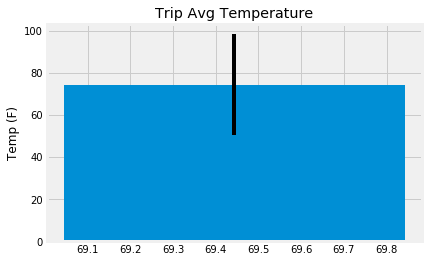

In [20]:
plt.bar(temp_new[1], height=temp_new[1] + 5, yerr=temp_new[2]-temp_new[0])
plt.title("Trip Avg Temperature")
plt.ylabel("Temp (F)")

In [21]:
# Calculate the rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
session.query(Station.station, Station.name, Station.latitude,\
            Station.longitude, Station.elevation, Measurement.prcp)\
.filter(Station.station==Measurement.station, Measurement.date>='2015-03-01', Measurement.date<='2015-03-31').order_by(Measurement.prcp.desc()).distinct().all()



[('USC00516128',
  'MANOA LYON ARBO 785.2, HI US',
  21.3331,
  -157.8025,
  152.4,
  2.07),
 ('USC00516128',
  'MANOA LYON ARBO 785.2, HI US',
  21.3331,
  -157.8025,
  152.4,
  2.02),
 ('USC00519523',
  'WAIMANALO EXPERIMENTAL FARM, HI US',
  21.33556,
  -157.71139,
  19.5,
  1.94),
 ('USC00516128',
  'MANOA LYON ARBO 785.2, HI US',
  21.3331,
  -157.8025,
  152.4,
  1.5),
 ('USC00519281',
  'WAIHEE 837.5, HI US',
  21.45167,
  -157.84888999999998,
  32.9,
  1.08),
 ('USC00516128',
  'MANOA LYON ARBO 785.2, HI US',
  21.3331,
  -157.8025,
  152.4,
  0.92),
 ('USC00516128',
  'MANOA LYON ARBO 785.2, HI US',
  21.3331,
  -157.8025,
  152.4,
  0.72),
 ('USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 0.65),
 ('USC00519281',
  'WAIHEE 837.5, HI US',
  21.45167,
  -157.84888999999998,
  32.9,
  0.61),
 ('USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6, 0.6),
 ('USC00519281',
  'WAIHEE 837.5, HI US',
  21.45167,
  -157.84888999999998,
  32.9,
  0.57),
 ('USC00

In [45]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs).label("tmin"), func.avg(Measurement.tobs).label("tavg"), func.max(Measurement.tobs).label("tmax")]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [46]:
normal=[]
for i in range(1, 32):
    day_avg=daily_normals("03-" + str(i).zfill(2))
    normal.append(day_avg)


In [53]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date
normals=list(np.ravel(normal[0]))


[(64.0, 70.0327868852459, 76.0)]

In [62]:
trip_dates=[]
day=1
for norm in normal:
    temp_dict={}
    trip="2015-03-" + str(day).zfill(2)
    normals=list(np.ravel(norm))
    temp_dict["date"]=trip
    temp_dict["tmin"]=normals[0]
    temp_dict["tavg"]=normals[1]
    temp_dict["tmax"]=normals[2]
    trip_dates.append(temp_dict)
    day=day+1
    

In [66]:
trip_dates_df=pd.DataFrame(trip_dates).set_index("date")

trip_dates_df

,tavg,tmax,tmin
date,,,
2015-03-01,70.032787,76.0,64.0
2015-03-02,70.366667,78.0,61.0
2015-03-03,70.068966,78.0,60.0
2015-03-04,69.272727,77.0,57.0
2015-03-05,67.890909,76.0,60.0
2015-03-06,69.203390,76.0,60.0
2015-03-07,69.172414,78.0,60.0
2015-03-08,68.724138,78.0,59.0
2015-03-09,68.561404,75.0,57.0


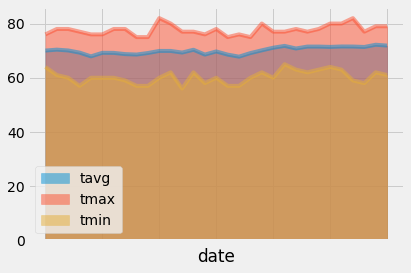

In [72]:
trip_dates_df.plot.area(stacked=False)
#missing the ticks for the dates

    